# Importing Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, pmap, random, lax, value_and_grad, tree_map, devices

from tqdm import trange
import pickle
import os.path as pt

In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

In [ ]:
attemptno = 2.1
n = 159912
loadpath = pt.abspath(pt.join(pt.abspath(''), '..', 'Data/Hyperparameters/LinearSum/' + str(n) + '_' + str(attemptno) + 'yvel' + '.pkl'))

In [ ]:
with open(loadpath, 'rb') as f:
    ydict = pickle.load(f)

In [ ]:
sigma_f, ell, sigma_n, z_fracs, v_vector, l_diag, l_odiag, trise, taudiff, lag = ydict["Parameters"]
elbo_history = ydict["ELBO History"]
trainind = ydict["Training Sets"]
isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag = ydict["Initial Parameters"]
num_f, num_b, num_ind, num_filt, num_tbin, num_mach = ydict["Training Parameters"]
f_maxt, time_bin = ydict["Filter Form"]

# Prior Functions

In [ ]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [ ]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

# Obtaining Training Data

## Importing Spike Trains and Finger Movement

In [ ]:
datapath = pt.abspath(pt.join(pt.abspath(''), '..', 'Data/Allfinger_veldata.h5'))
alldata = pd.read_hdf(datapath) # Import DataFrame

In [ ]:
data = [alldata.loc[i] for i in trainind]

In [ ]:
subsamp = int(time_bin/0.001)
spikedat = [data[i].spikes.to_numpy()[:num_tbin, :num_filt].T[:,::subsamp, None] for i in trainind]

In [ ]:
ytime = [(data[i].index / np.timedelta64(1, 's')).to_numpy()[:num_tbin:subsamp] for i in trainind] # Get spikes/output time array

In [ ]:
# Get y velocities
yraw = [data[i].finger_vel.y.to_numpy()[:num_tbin:subsamp].reshape(n + 1, 1) for i in trainind]

## Standardising Data

In [ ]:
# Set variance to 1.0
yvel = [yraw[i] / np.std(yraw[i]) for i in trainind]

In [ ]:
k = np.floor(f_maxt/time_bin).astype(np.int16) # Maximum index of filter data

ftime = np.linspace(0.0, f_maxt, k + 1).reshape((k + 1, 1)) # Filter corresponding time array

In [ ]:
batch_size = num_filt // num_mach
# FFT of spike train
spikepad = [np.hstack((spikedat[i], np.zeros((num_filt, k, 1)))) for i in trainind]
spikefft = [np.fft.rfft(spikepad[i], axis=1) for i in trainind]
fftlen = [np.shape(spikefft[i])[1] for i in trainind]
spikefft = [spikefft[i].reshape(num_mach, batch_size, fftlen[i], 1) for i in trainind]
spikefft = [[spikefft[j][i] for j in range(len(trainind))] for i in range(num_mach)]
spikefft = jnp.asarray(spikefft)
yvel = jnp.asarray(yvel)

In [ ]:
num_train = len(trainind)
spikeffta = [np.asarray([spikefft[i][j] for i in range(num_mach)]) for j in range(num_train)]
spikefftf = [spikeffta[i].reshape(num_filt, fftlen[i], 1) for i in range(num_train)]

In [ ]:
Diag = vmap(jnp.diag)

In [ ]:
PDiag = pmap(Diag)

In [ ]:
@jit
def Set(Matrix, Indices, NewVals):
  return Matrix.at[:, Indices[0], Indices[1]].set(NewVals)

In [ ]:
PSet = pmap(Set, in_axes=(0, None, 0,))

In [ ]:
@jit
def LowerSolv(MatA, MatB):
  return jsc.linalg.solve_triangular(MatA, MatB, lower = True)

In [ ]:
VLS = vmap(LowerSolv)

In [ ]:
@partial(jit, static_argnums = (1, 2, 3,))
def OUTconvolve(Filters, Num_Filt, K, N, Spike_FFT):
  Pad = jnp.hstack((Filters, jnp.zeros((Num_Filt, N, 1))))
  Pred_fft = jnp.fft.rfft(Pad, axis = -2)
  Pred_sum = jnp.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = jnp.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

# Y Velocity

In [ ]:
print(elbo_history.shape)

(22000,)


(-0.2, 0.0)

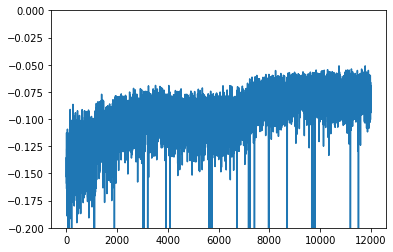

In [ ]:
plt.plot(elbo_history[8000:20000])
plt.ylim([-0.2, 0.0])

In [ ]:
indices = jnp.asarray(jnp.tril_indices(num_ind, -1))

In [ ]:
ilag = ilag ** 2

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag) + ilag

idz = PDiag(np.exp(il_diag))
il_matrix = PSet(idz, indices, il_odiag)


lag = lag ** 2

z_vector = (0.5 * np.sin( np.pi * (z_fracs - 0.5)) + 0.5) * (ftime[-1] - lag) + lag

d = PDiag(np.exp(l_diag))
l_matrix = PSet(d, indices, l_odiag)

In [ ]:
isigma_ff = isigma_f.reshape(num_filt, 1)
iellf = iell.reshape(num_filt, 1)
iz_vectorf = iz_vector.reshape(num_filt, num_ind, 1)
iv_vectorf = iv_vector.reshape(num_filt, num_ind, 1)
il_matrixf = il_matrix.reshape(num_filt, num_ind, num_ind)
itrisef = itrise.reshape(num_filt, 1)
itaudifff = itaudiff.reshape(num_filt, 1)
ilagf = ilag.reshape(num_filt, 1)

sigma_ff = sigma_f.reshape(num_filt, 1)
ellf = ell.reshape(num_filt, 1)
z_vectorf = z_vector.reshape(num_filt, num_ind, 1)
v_vectorf = v_vector.reshape(num_filt, num_ind, 1)
l_matrixf = l_matrix.reshape(num_filt, num_ind, num_ind)
trisef = trise.reshape(num_filt, 1)
taudifff = taudiff.reshape(num_filt, 1)
lagf = lag.reshape(num_filt, 1)

## Variational Predictions

In [ ]:
fpred_points = ftime.copy()

In [ ]:
scisigmaf = isigma_ff[:, None]
sciellf = iellf[:, None]
scitrisef = itrisef[:, None]
scitaudifff = itaudifff[:, None]
scilagf = ilagf[:, None]

ikmm = Squared_exp(iz_vectorf, iz_vectorf.transpose(0, 2, 1), scisigmaf, sciellf)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vectorf, fpred_points.T, scisigmaf, sciellf)
ibzast = VLS(icpred, ikzast)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, scitrisef, scitaudifff, scilagf)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vectorf)

ikastast = Squared_exp(fpred_points, fpred_points.T, scisigmaf, sciellf)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrixf @ il_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [ ]:
scfsigmaf = sigma_ff[:, None]
scfellf = ellf[:, None]
scftrisef = trisef[:, None]
scftaudifff = taudifff[:, None]
scflagf = lagf[:, None]

kmm = Squared_exp(z_vectorf, z_vectorf.transpose(0, 2, 1), scfsigmaf, scfellf)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Squared_exp(z_vectorf, fpred_points.T, scfsigmaf, scfellf)
bzast = VLS(cpred, kzast)
bzastT = bzast.transpose(0, 2, 1)
predenv = AlpEnvelope(fpred_points, scftrisef, scftaudifff, scflagf)
predenvT = predenv.transpose(0, 2, 1)
meanpred = predenv * (bzastT @ v_vectorf)

kastast = Squared_exp(fpred_points, fpred_points.T, scfsigmaf, scfellf)
covpred = predenv * (kastast + bzastT @ (l_matrixf @ l_matrixf.transpose(0, 2, 1) - np.eye(num_ind)) @ bzast) * predenvT

2022-05-29 11:42:29.726886: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.18GiB (rounded to 2343121152)requested by op 
2022-05-29 11:42:29.727307: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:491] ****************************___________________*******************************************__________
2022-05-29 11:42:29.727517: E external/org_tensorflow/tensorflow/compiler/xla/pjrt/pjrt_stream_executor_client.cc:2141] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2343121040 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   59.55MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.18GiB
     preallocated temp allocation:         0B
                 total allocation:    2.24GiB
              total fragmentation:         0B (0.00%)
Peak buffe

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 2343121040 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   59.55MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.18GiB
     preallocated temp allocation:         0B
                 total allocation:    2.24GiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 2.18GiB
		Operator: op_name="jit(matmul)/jit(main)/dot_general[dimension_numbers=(((2,), (1,)), ((0,), (0,))) precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_24503/3571552522.py" source_line=17
		XLA Label: custom-call
		Shape: f64[130,1501,1501]
		==========================

	Buffer 2:
		Size: 29.77MiB
		Entry Parameter Subshape: f64[130,20,1501]
		==========================

	Buffer 3:
		Size: 29.77MiB
		Entry Parameter Subshape: f64[130,1501,20]
		==========================



: 

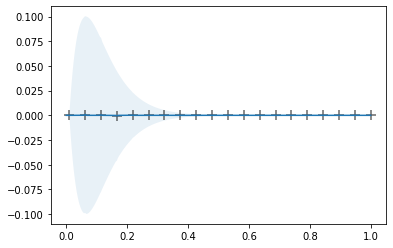

In [ ]:
ipredindenv = AlpEnvelope(iz_vectorf, scitrisef, scitaudifff, scilagf)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vectorf[index], (ipredindenv * (icpred @ iv_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)

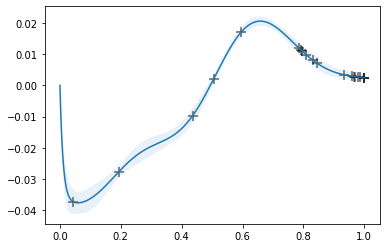

In [ ]:
predindenv = AlpEnvelope(z_vectorf, scftrisef, scftaudifff, scflagf)

plt.plot(fpred_points, meanpred[index])
s2 = np.sqrt(np.diag(covpred[index]))
fill = (meanpred[index].flatten() - s2, meanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(z_vectorf[index], (predindenv * (cpred @ v_vectorf))[index], s = 100, marker = '+', c='k', alpha = 0.6)

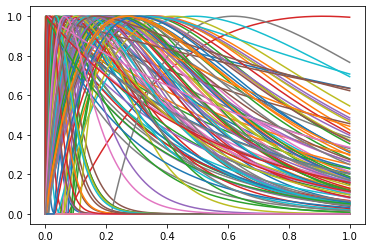

In [ ]:
envelopes = AlpEnvelope(ftime, scftrisef, scftaudifff, scflagf)
for i in envelopes:
  plt.plot(ftime, i)

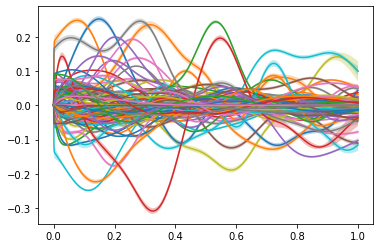

In [ ]:
for inds in range(num_filt):
  plt.plot(fpred_points, meanpred[inds])
  s2 = np.sqrt(np.diag(covpred[inds]))
  fill = (meanpred[inds].flatten() - s2, meanpred[inds].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.3)
  #plt.scatter(z_vectorf[inds], (predindenv * (cpred @ v_vectorf))[inds], s = 100, marker = '+', c='k', alpha = 0.6)

In [ ]:
@partial(jit, static_argnums = (1, 2, 3,))
def OUTconvolve(Filters, Num_Filt, K, N, Spike_FFT):
  Pad = jnp.hstack((Filters, jnp.zeros((Num_Filt, N, 1))))
  Pred_fft = jnp.fft.rfft(Pad, axis = -2)
  Pred_sum = jnp.sum(Pred_fft * Spike_FFT, axis = 0)
  Pred_fitfft = jnp.fft.irfft(Pred_sum, K + N + 1, axis = -2)[ : N + 1]
  return Pred_fitfft

In [ ]:
plotting = 2

In [ ]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

imeanpredict = OUTconvolve(imeanpred, num_filt, k, n, spikefftf[plotting])
imeanpredictns2 = OUTconvolve(imeanpred - is2, num_filt, k, n, spikefftf[plotting])
imeanpredictps2 = OUTconvolve(imeanpred + is2, num_filt, k, n, spikefftf[plotting])

In [ ]:
s2 = np.sqrt(np.diagonal(covpred, axis1=1, axis2=2)).reshape((num_filt, k + 1, 1))

meanpredict = OUTconvolve(meanpred, num_filt, k, n, spikefftf[plotting])
meanpredictns2 = OUTconvolve(meanpred - s2, num_filt, k, n, spikefftf[plotting])
meanpredictps2 = OUTconvolve(meanpred + s2, num_filt, k, n, spikefftf[plotting])

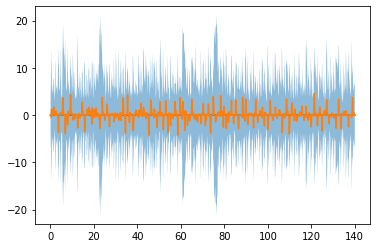

In [ ]:
plt.plot(ytime[plotting], imeanpredict)
plt.plot(ytime[plotting], yvel[plotting])
plt.fill_between(ytime[plotting].flatten(), imeanpredictns2.flatten() - isigma_n,  
                  imeanpredictps2.flatten() + isigma_n, alpha = 0.5)

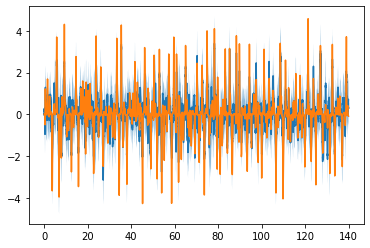

In [ ]:
plt.plot(ytime[plotting], meanpredict)
plt.plot(ytime[plotting], yvel[plotting])
plt.fill_between(ytime[plotting].flatten(), meanpredictns2.flatten() - sigma_n,  
                  meanpredictps2.flatten() + sigma_n, alpha = 0.5)

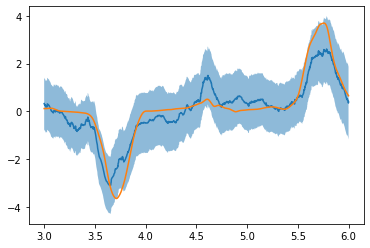

In [ ]:
ysnip = yvel[:, 3000:6000]
timesnip = [i[3000:6000] for i in ytime]
meansnip = meanpredict[3000:6000]
meansnipns2 = meanpredictns2[3000:6000]
meansnipps2 = meanpredictps2[3000:6000]
plt.plot(timesnip[plotting], meansnip)
plt.plot(timesnip[plotting], ysnip[plotting])
plt.fill_between(timesnip[plotting].flatten(), meansnipns2.flatten() - sigma_n,  
                  meansnipps2.flatten() + sigma_n, alpha = 0.5)

# On Test Data

In [ ]:
testind = (3,)
num_test = len(testind)

In [ ]:
testdat = [alldata.loc[i] for i in testind]

In [ ]:
tes_bins = 161393
ntest = tes_bins - 1

In [ ]:
testspike = [testdat[i].spikes.to_numpy()[:tes_bins, :num_filt].T[:,::subsamp, None] for i in range(num_test)]

In [ ]:
testpad = [jnp.hstack((i, jnp.zeros((num_filt, k, 1)))) for i in testspike]
testspikefft = jnp.asarray([np.fft.rfft(i, axis = -2) for i in testpad])

In [ ]:
testtime = [(testdat[i].index / np.timedelta64(1, 's')).to_numpy()[:tes_bins:subsamp] for i in range(num_test)]

In [ ]:
# Get x velocities
yrawtes = [testdat[i].finger_vel.y.to_numpy()[:tes_bins:subsamp].reshape(ntest + 1, 1) for i in range(num_test)]

## Standardising Data

In [ ]:
# Set variance to 1.0
ytest = np.asarray([yrawtes[i] / np.std(yrawtes[i]) for i in range(num_test)])

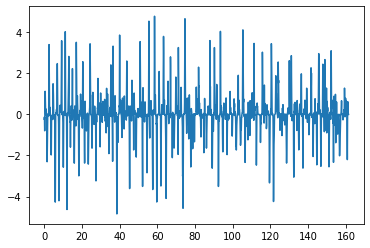

In [ ]:
for i in range(num_test):
  plt.plot(testtime[i], ytest[i])

## Plotting vs Test

In [ ]:
tplotting = 0

In [ ]:
tmeanpredict = OUTconvolve(meanpred, num_filt, k, ntest, testspikefft[tplotting])
tmeanpredictns2 = OUTconvolve(meanpred - s2, num_filt, k, ntest, testspikefft[tplotting])
tmeanpredictps2 = OUTconvolve(meanpred + s2, num_filt, k, ntest, testspikefft[tplotting])

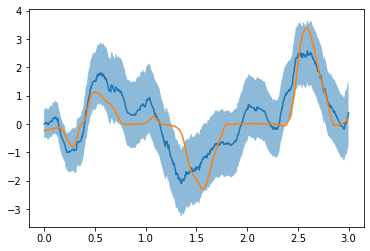

In [ ]:
plt.plot(testtime[tplotting][:3000], tmeanpredict[:3000])
plt.plot(testtime[tplotting][:3000], ytest[tplotting][:3000])
plt.fill_between(testtime[tplotting].flatten()[:3000], tmeanpredictns2.flatten()[:3000] - sigma_n,  
                  tmeanpredictps2.flatten()[:3000] + sigma_n, alpha = 0.5)

## R^2

## Y Velocity

### Test Data

In [ ]:
rtplotting = 0

In [ ]:
alltestpredict = np.asarray([OUTconvolve(meanpred, num_filt, k, ntest, i) for i in testspikefft])

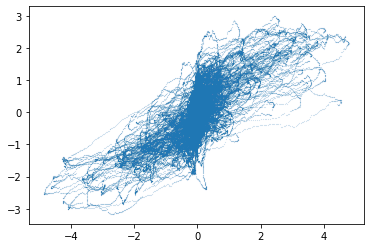

In [ ]:
plt.scatter(ytest[rtplotting], alltestpredict[rtplotting], s=.005)

In [ ]:
tess = np.sum(np.asarray([np.square(ytest[i] - alltestpredict[i]) for i in range(num_test)]))
ttss = np.sum(np.asarray([np.square(ytest[i] - np.mean(ytest[i])) for i in range(num_test)]))
tr2 = 1 - tess/ttss
print(tr2)

0.5551635070053071


### Training Data

In [ ]:
rplotting = 0

In [ ]:
allpredict = np.asarray([OUTconvolve(meanpred, num_filt, k, n, i) for i in spikefftf])

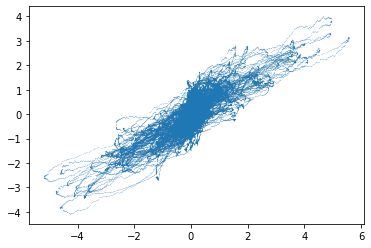

In [ ]:
plt.scatter(yvel[rplotting], allpredict[rplotting], s=.005)

In [ ]:
ess = np.sum(np.asarray([np.square(yvel[i] - allpredict[i]) for i in range(num_train)]))
tss = np.sum(np.asarray([np.square(yvel[i] - np.mean(yvel[i])) for i in range(num_train)]))
r2 = 1 - ess/tss
print(r2)

0.7386529874523753
